In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
yazanaboeloun_arabic_path = kagglehub.dataset_download('yazanaboeloun/arabic')

print('Data source import complete.')


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
yazanaboeloun_arabic_path = kagglehub.dataset_download('yazanaboeloun/arabic')

print('Data source import complete.')


Data source import complete.


In [ ]:
import os

# Define the dataset path
dataset_path = yazanaboeloun_arabic_path

# Check if the dataset path exists
if os.path.exists(dataset_path):
    print("Dataset path exists!")
    print("Files in the dataset directory:")
    print(os.listdir(dataset_path))  # List files to confirm the structure
else:
    print("Dataset path does not exist.")

Dataset path exists!
Files in the dataset directory:
['.gitignore', 'preprocessed']


In [ ]:
import os
import cv2
import pandas as pd
import numpy as np
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader,ConcatDataset
from torchvision import transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim

In [ ]:
data_path = yazanaboeloun_arabic_path
dataset_path = os.path.join(data_path, 'preprocessed')

In [ ]:
%cp -r /content/drive/MyDrive/Arabic-Handwritten-Text-Identification-Using-Deep-Learning-main/Arabic-Handwritten-Text-Identification-Using-Deep-Learning-main/utilities .

In [ ]:
# Load Images from File
def load_images_from_directory(directory, target_size=(256, 128)):
    data = []
    for root, _, files in os.walk(directory):

        for filename in files:
            if filename.endswith(".jpg") or filename.endswith(".png"):
                img = cv2.imread(os.path.join(root, filename), cv2.IMREAD_GRAYSCALE)
                if img is not None:

                    data.append({'filename': filename, 'image': img})
    return data

In [ ]:
def load_images_to_dataframe(directory):
    """
    Load images from a directory and return a DataFrame containing the images and their filenames.

    Parameters:
    directory (str): The directory containing the images.

    Returns:
    pd.DataFrame: A DataFrame with columns 'filename' and 'image'.
    """

    data = load_images_from_directory(directory)
    print('data')
    df = pd.DataFrame(data)
    df.set_index('filename', inplace=True)
    df['Target'] = df.index.map(lambda x: x.split('_')[0])

    return df


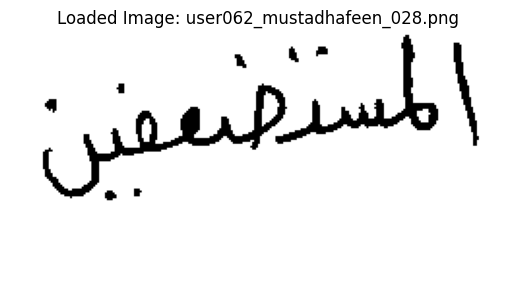

In [ ]:
import cv2
from matplotlib import pyplot as plt

# Check the files and choose one to load
image_filename = os.listdir(dataset_path)[0]  # Replace with the actual image filename if needed
image_path = os.path.join(dataset_path, image_filename)

# Load the image using OpenCV
image = cv2.imread(image_path)

# Check if the image is loaded successfully
if image is not None:
    # Convert the image from BGR to RGB for correct display with Matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image
    plt.imshow(image_rgb)
    plt.axis("off")  # Hide the axes
    plt.title(f"Loaded Image: {image_filename}")
    plt.show()
else:
    print(f"Failed to load image from {image_path}")


In [ ]:
df = load_images_to_dataframe(dataset_path)

# Encode the labels
label_encoder = LabelEncoder()
df['Target'] = label_encoder.fit_transform(df['Target'])

# Split the data into training and testing sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
# Further split the training set into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


data


In [ ]:
# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # Access the stored image data in grayscale
        image = self.dataframe.iloc[idx, 0]  # 'image' column has the image data (grayscale)
        label = self.dataframe.iloc[idx, 1]  # 'Target' column has the label

        # Convert grayscale image to RGB if needed
        image = np.expand_dims(image, axis=-1)  # Add channel dimension (H, W, 1)
        image = np.repeat(image, 3, axis=-1)  # Convert to RGB by duplicating the grayscale channel

        # Convert numpy array to PIL image
        image = Image.fromarray(image)

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)

        return image, label

**Data Augmentation**

In [ ]:
transform_group1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

transform_group2 = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.ToTensor(),
])

# Group 2: Color Jitter
transform_group3 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
])

# Group 3: Resize
transform_group4 = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

In [ ]:
dataset1 = ImageDataset(dataframe=train_df, transform=transform_group1)
dataset2 = ImageDataset(dataframe=train_df, transform=transform_group2)
dataset3 = ImageDataset(dataframe=train_df, transform=transform_group3)
dataset4 = ImageDataset(dataframe=train_df, transform=transform_group4)

In [ ]:
combined_dataset = ConcatDataset([dataset1, dataset2, dataset3])

In [ ]:
dataloader = DataLoader(combined_dataset, batch_size=32, shuffle=True)

In [ ]:
print(df['Target'].unique())

[ 1 70 72  2  3 73 31  4  9 16 49  0 11 27 37 14 80 76 39 19 69 41 79 62
 25 48 52 36 44 35 26 60 45 81  7 40 24 57  8 55 68 78 63 58 23 64 33  5
 50 51 66 15 29 32 12 53 30 74 38 21 56 42 17 28  6 59 65 71 75 47 18 46
 10 34 77 13 67 61 43 54 22 20]


In [ ]:
# Define the transformation
# transform = transforms.Compose([
#     transforms.Resize((128, 128)),
#     transforms.ToTensor(),
# ])

# # Create the dataset and dataloader
# dataset = ImageDataset(dataframe=train_df, transform=transform)

# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Define the model class
class SimpleCNN(nn.Module):
    def __init__(self, num_filters, kernel_size, stride, padding, fc_neurons, dropout_rate, pool_size, pool_type="max"):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, num_filters, kernel_size=kernel_size, stride=stride, padding=padding)
        self.conv2 = nn.Conv2d(num_filters, num_filters * 2, kernel_size=kernel_size, stride=stride, padding=padding)

        # Pooling layer selection (max or average pooling)
        if pool_type == "max":
            self.pool = nn.MaxPool2d(kernel_size=pool_size, stride=pool_size)
        elif pool_type == "avg":
            self.pool = nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)

        self.dropout = nn.Dropout(dropout_rate)

        self.fc1 = nn.Linear(num_filters * 2 * 16 * 16, fc_neurons)  # Initialize with a default size
        self.fc2 = nn.Linear(fc_neurons, 82)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Dynamically determine the input size for fc1
        x = x.view(x.size(0), -1)  # Flatten the output
        if x.shape[1] != self.fc1.in_features:
            self.fc1 = nn.Linear(x.shape[1], self.fc2.in_features)  # Adjust fc1 if needed
            print("fc1 input size adjusted to:", x.shape[1])

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

    def _calculate_fc1_input_size(self, num_filters, kernel_size, stride, padding, pool_size):
        # Create a dummy input tensor
        dummy_input = torch.randn(1, 3, 128, 128)

        # Pass the dummy input through the convolutional and pooling layers
        dummy_output = self.pool(F.relu(nn.Conv2d(3, num_filters, kernel_size=kernel_size, stride=stride, padding=padding)(dummy_input)))
        dummy_output = self.pool(F.relu(nn.Conv2d(num_filters, num_filters * 2, kernel_size=kernel_size, stride=stride, padding=padding)(dummy_output)))

        # Calculate the flattened size of the output
        return dummy_output.view(1, -1).shape[1]



In [ ]:
# Baseline configuration
base_config = {
    "num_filters": 16,
    "kernel_size": 3,
    "stride": 1,
    "padding": 1,
    "fc_neurons": 128,
    "dropout_rate": 0,
    "pool_size": 2,
    "pool_type": "max",
    "learning_rate": 0.001,
    "batch_size": 32,
    "weight_decay": 0.0,
    "optimizer_name": "Adam",
}

# Parameters to tune (one at a time)
parameters_to_tune = {
    "num_filters": [16, 32],
    "kernel_size": [3, 5],
    "stride": [1,2],
    "padding": [0,1],
    "fc_neurons": [128,256],
    "dropout_rate": [0,0.2],
    "pool_size": [2,3],
    "pool_type": ["avg"],
    "learning_rate": [0.001,0.0005],
    "batch_size": [32,64],
    "weight_decay": [0.0,0.01],
    "optimizer_name": ["Adam","SGD"],
}

In [ ]:
for param, values in parameters_to_tune.items():
    for value in values:
        # Update the current parameter in the base config
        current_config = base_config.copy()
        current_config[param] = value

        # Create the dataloader with the updated batch size
        dataloader = DataLoader(combined_dataset, batch_size=current_config["batch_size"], shuffle=True)

        # Initialize the model
        model = SimpleCNN(
            num_filters=current_config["num_filters"],
            kernel_size=current_config["kernel_size"],
            stride=current_config["stride"],
            padding=current_config["padding"],
            fc_neurons=current_config["fc_neurons"],
            dropout_rate=current_config["dropout_rate"],
            pool_size=current_config["pool_size"],
            pool_type=current_config["pool_type"],
        )

        # Define optimizer
        if current_config["optimizer_name"] == "Adam":
            optimizer = optim.Adam(model.parameters(), lr=current_config["learning_rate"], weight_decay=current_config["weight_decay"])
        elif current_config["optimizer_name"] == "SGD":
            optimizer = optim.SGD(model.parameters(), lr=current_config["learning_rate"], weight_decay=current_config["weight_decay"])

        # Define loss function
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 5
        loss_per_epoch = []

        for epoch in range(num_epochs):
            running_loss = 0.0
            for images, labels in dataloader:
                optimizer.zero_grad()
                labels = labels.long()

                # Forward pass (fc1 adjustment happens here if needed)
                outputs = model(images)

                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_loss = running_loss / len(dataloader)
            loss_per_epoch.append(avg_loss)
            print(f'Tuning {param}={value}, Epoch={epoch+1}, Loss={avg_loss}')


        # Save the model
        model_name = f'model_{param}{value}.pth'
        torch.save(model, os.path.join('/content/drive/MyDrive/cnn_models_augmented_data', model_name))

        # Save the loss vs. epoch data
        log_name = f'loss_{param}{value}.txt'
        with open(os.path.join('/content/drive/MyDrive/logs_augmented', log_name), 'w') as f:
            for epoch, loss in enumerate(loss_per_epoch, 1):
                f.write(f'Epoch {epoch}, Loss: {loss}\n')

fc1 input size adjusted to: 65536
Tuning num_filters=16, Epoch=1, Loss=4.330350749275901
Tuning num_filters=16, Epoch=2, Loss=3.8886219306425613
Tuning num_filters=16, Epoch=3, Loss=3.716588181582364
Tuning num_filters=16, Epoch=4, Loss=3.629050475467335
Tuning num_filters=16, Epoch=5, Loss=3.5748000621795653
fc1 input size adjusted to: 131072
Tuning num_filters=32, Epoch=1, Loss=4.304433562972329


KeyboardInterrupt: 

In [ ]:
#Save the model's state_dict
#torch.save(model.state_dict(), '/content/drive/MyDrive/cnn_proj_models/cnn_test')

#To load it later:
model = SimpleCNN(
    num_filters=base_config["num_filters"],
    kernel_size=base_config["kernel_size"],
    stride=base_config["stride"],
    padding=base_config["padding"],
    fc_neurons=256,
    dropout_rate=0.3,
    pool_size=base_config["pool_size"],
    pool_type=base_config["pool_type"]
)
model.load_state_dict(torch.load('/content/drive/MyDrive/cnn_proj_models/model_fc_neurons256.pth'))


<ipython-input-10-8483f8712ed5>:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/cnn_proj_models/model_fc_neurons25

<All keys matched successfully>

In [ ]:
# Assuming you already have your dataset and dataloaders ready
# Example: train_loader, val_loader

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss()  # or the appropriate loss for your task
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adjust learning rate if needed

# Number of additional epochs to train
num_epochs = 15  # Update this to your desired number

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0

    for inputs, labels in dataloader:
        optimizer.zero_grad()  # Clear gradients from the previous step
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

Epoch 1/15, Loss: 0.5153155087938776
Epoch 2/15, Loss: 0.393408422631657
Epoch 3/15, Loss: 0.3312929634247785
Epoch 4/15, Loss: 0.2804775101173183
Epoch 5/15, Loss: 0.2543026895829193
Epoch 6/15, Loss: 0.2391717100981623
Epoch 7/15, Loss: 0.2140477980517418
Epoch 8/15, Loss: 0.20052805420456696
Epoch 9/15, Loss: 0.1771318913720872
Epoch 10/15, Loss: 0.1591620927312128
Epoch 11/15, Loss: 0.15080908696045695
Epoch 12/15, Loss: 0.13345368404913208
Epoch 13/15, Loss: 0.12577146495206523
Epoch 14/15, Loss: 0.11702878720572461
Epoch 15/15, Loss: 0.11167127481641491


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/cnn_proj_models/fc_neurons_256_epochs_15')

In [ ]:
df['Target'].value_counts()

,count
Target,
1,100
68,100
21,100
38,100
74,100
...,...
25,100
62,100
20,100


In [ ]:
val_dataset = ImageDataset(dataframe=val_df, transform=transform)
test_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


model.eval()

# No need to track gradients during inference
correct_predictions = 0
total_predictions = 0

# Iterate over the test dataset
with torch.no_grad():  # Disable gradient calculations for evaluation
    for images, labels in test_dataloader:
        labels = labels.long()  # Ensure the labels are of type Long (int64)

        # Forward pass
        outputs = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate the accuracy
accuracy = 100 * correct_predictions / total_predictions
print(f'Accuracy on the val set: {accuracy:.2f}%')

Accuracy on the val set: 30.98%


In [ ]:
test_dataset = ImageDataset(dataframe=test_df, transform=transform)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)


model.eval()

# No need to track gradients during inference
correct_predictions = 0
total_predictions = 0

# Iterate over the test dataset
with torch.no_grad():  # Disable gradient calculations for evaluation
    for images, labels in test_dataloader:
        labels = labels.long()  # Ensure the labels are of type Long (int64)

        # Forward pass
        outputs = model(images)

        # Get the predicted class with the highest probability
        _, predicted = torch.max(outputs, 1)

        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Calculate the accuracy
accuracy = 100 * correct_predictions / total_predictions
print(f'Accuracy on the val set: {accuracy:.2f}%')

# Task 3

In [ ]:
# Define the transformation for ResNet and AlexNet
transform_resnet_alexnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
transform_group1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_group2 = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Group 2: Color Jitter
transform_group3 = transforms.Compose([
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [ ]:
dataset1 = ImageDataset(dataframe=train_df, transform=transform_group1)
dataset2 = ImageDataset(dataframe=train_df, transform=transform_group2)
dataset3 = ImageDataset(dataframe=train_df, transform=transform_group3)
dataset4 = ImageDataset(dataframe=train_df, transform=transform_resnet_alexnet)

val_dataset = ImageDataset(dataframe=val_df, transform=transform_resnet_alexnet)
test_dataset = ImageDataset(dataframe=test_df, transform=transform_resnet_alexnet)

combined_dataset = ConcatDataset([dataset1, dataset2, dataset3, dataset4])

combined_loader = DataLoader(combined_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from torchvision import models

In [ ]:
# Load a non-pretrained ResNet model
model_resnet = models.resnet18(weights=None)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 82)  # Assuming 82 classes

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet = model_resnet.to(device)

# Define the loss function and optimizer
criterion_resnet = nn.CrossEntropyLoss()
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.00001)

In [ ]:
import json

# Training loop with validation for ResNet
num_epochs = 50
log_data = {'epoch': [], 'training_loss': [], 'validation_loss': [], 'validation_accuracy': []}

for epoch in range(num_epochs):
    model_resnet.train()
    running_loss = 0.0
    for images, labels in combined_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer_resnet.zero_grad()
        outputs = model_resnet(images)
        loss = criterion_resnet(outputs, labels)
        loss.backward()
        optimizer_resnet.step()
        running_loss += loss.item()

    training_loss = running_loss / len(combined_loader)
    print(f'Epoch {epoch+1}, Training Loss: {training_loss}')

    # Validation
    model_resnet.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            loss = criterion_resnet(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    validation_loss = val_loss / len(val_dataloader)
    validation_accuracy = 100 * correct / total
    print(f'Epoch {epoch+1}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}%')

    # Save log data
    log_data['epoch'].append(epoch + 1)
    log_data['training_loss'].append(training_loss)
    log_data['validation_loss'].append(validation_loss)
    log_data['validation_accuracy'].append(validation_accuracy)

# Save log data to a file
with open('training_log.json', 'w') as log_file:
    json.dump(log_data, log_file)

print('Finished Training')

# Save the model
torch.save(model_resnet.state_dict(), 'resnet_model_lr_0.001.pth')

# # Evaluate the model on the test set
# model_resnet.eval()
# correct = 0
# total = 0
# with torch.no_grad():
#     for images, labels in test_loader_resnet_alexnet:
#         images, labels = images.to(device), labels.to(device)
#         outputs = model_resnet(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

# print(f'Accuracy on the test set: {100 * correct / total}%')

Epoch 1, Training Loss: 4.29192317312414
Epoch 1, Validation Loss: 4.132739328202748, Validation Accuracy: 5.828220858895706%
Epoch 2, Training Loss: 3.8401382255554197
Epoch 2, Validation Loss: 3.726433072771345, Validation Accuracy: 11.042944785276074%
Epoch 3, Training Loss: 3.4789125420830467
Epoch 3, Validation Loss: 3.443730967385428, Validation Accuracy: 17.63803680981595%
Epoch 4, Training Loss: 3.2151575977152045
Epoch 4, Validation Loss: 3.2620488007863364, Validation Accuracy: 17.024539877300615%
Epoch 5, Training Loss: 3.011609050577337
Epoch 5, Validation Loss: 3.01163048971267, Validation Accuracy: 22.392638036809817%
Epoch 6, Training Loss: 2.8272727649862115
Epoch 6, Validation Loss: 2.8851920195988248, Validation Accuracy: 26.993865030674847%
Epoch 7, Training Loss: 2.6860038705305618
Epoch 7, Validation Loss: 2.7302442505246116, Validation Accuracy: 29.141104294478527%
Epoch 8, Training Loss: 2.534316433993253
Epoch 8, Validation Loss: 2.599452030091059, Validation Ac

In [ ]:
def train_and_evaluate(model, criterion, optimizer, num_epochs, train_loader, val_loader, test_loader, device, model_name, lr):
    log_data = {'epoch': [], 'training_loss': [], 'validation_loss': [], 'validation_accuracy': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        training_loss = running_loss / len(train_loader)
        print(f'Epoch {epoch+1}, Training Loss: {training_loss}')

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        validation_loss = val_loss / len(val_loader)
        validation_accuracy = 100 * correct / total
        print(f'Epoch {epoch+1}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}%')

        # Save log data
        log_data['epoch'].append(epoch + 1)
        log_data['training_loss'].append(training_loss)
        log_data['validation_loss'].append(validation_loss)
        log_data['validation_accuracy'].append(validation_accuracy)

    # Save log data to a file
    log_filename = f'{model_name}_training_log_lr_{lr}_epochs_{num_epochs}.json'
    with open(log_filename, 'w') as log_file:
        json.dump(log_data, log_file)

    print('Finished Training')

    # Save the model
    model_filename = f'{model_name}_model_lr_{lr}_epochs_{num_epochs}.pth'
    torch.save(model.state_dict(), model_filename)

    # Evaluate the model on the test set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_accuracy = 100 * correct / total
    print(f'Accuracy on the test set: {test_accuracy}%')
    return test_accuracy

In [ ]:
# Hyperparameters
learning_rates = [0.001, 0.0001]
num_epochs_list = [10, 20]

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loop over learning rates and number of epochs
for lr in learning_rates:
    for num_epochs in num_epochs_list:
        # ResNet
        model_resnet = models.resnet18(pretrained=False)
        num_ftrs = model_resnet.fc.in_features
        model_resnet.fc = nn.Linear(num_ftrs, 82)  # Assuming 82 classes
        model_resnet = model_resnet.to(device)
        criterion_resnet = nn.CrossEntropyLoss()
        optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=lr)
        print(f'Training ResNet with learning rate {lr} and {num_epochs} epochs')
        train_and_evaluate(model_resnet, criterion_resnet, optimizer_resnet, num_epochs, combined_loader, val_dataloader, test_loader, device, 'resnet', lr)

        # AlexNet
        model_alexnet = models.alexnet(pretrained=False)
        num_ftrs = model_alexnet.classifier[6].in_features
        model_alexnet.classifier[6] = nn.Linear(num_ftrs, 82)  # Assuming 82 classes
        model_alexnet = model_alexnet.to(device)
        criterion_alexnet = nn.CrossEntropyLoss()
        optimizer_alexnet = optim.Adam(model_alexnet.parameters(), lr=lr)
        print(f'Training AlexNet with learning rate {lr} and {num_epochs} epochs')
        train_and_evaluate(model_alexnet, criterion_alexnet, optimizer_alexnet, num_epochs, combined_loader, val_dataloader, test_loader, device, 'alexnet', lr)

Training ResNet with learning rate 0.001 and 10 epochs
Epoch 1, Training Loss: 3.046627516961195
Epoch 1, Validation Loss: 2.5811139458701726, Validation Accuracy: 31.441717791411044%
Epoch 2, Training Loss: 1.874683983898423
Epoch 2, Validation Loss: 2.0310470944359187, Validation Accuracy: 42.02453987730061%
Epoch 3, Training Loss: 1.1325722987297286
Epoch 3, Validation Loss: 1.6328735493478321, Validation Accuracy: 53.68098159509202%
Epoch 4, Training Loss: 0.6787237408907645
